In [1]:
import sys
import os
import cv2
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from numpy import pi, matmul,sqrt,dot,array,zeros,cos,sin,pi,arccos,arctan
from torch.utils.data import DataLoader
from func import OR,heatplot,calmisorientation,mat2plot, match,imgshow,calpoint,L2,L1,ipfread,misorientation
from Class import Exp,Data,Cluster
import torch.nn.functional as F
import matplotlib.patches as patches
from multiprocessing import Process, Pool
class Dataset(torch.utils.data.Dataset):
    def __init__(self,bef,im,target):
        self.bef=bef
        self.im=im
        self.target=target
    def __getitem__(self,index):
        X=self.bef[index]
        Y=self.target[index]
        im=self.im[index]
        return torch.tensor(X,dtype=torch.float32),torch.tensor(Y,dtype=torch.long),im
    def __len__(self):
        return len(self.bef)
def negsample(corner):
    mat=np.zeros([500,500])
    for (i,j) in corner:
        for k in range(max(0,i-49),min(500,i+50)):
            for l in range(max(0,j-49),min(500,j+50)):
                mat[k,l]=1
    cand = []
    for i in range(451):
        for j in range(451):
            if not mat[i][j]:
                cand.append([i,j])
    return random.sample(cand,len(corner))


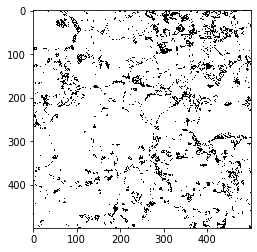

In [2]:
data=Data("data/train/20200916/before/")
ipf=ipfread("data/train/20200916/before/")
orient=data.data["Orient"]
inv = np.load("new_inv.npy")
h,w=orient.shape[0],orient.shape[1]
plt.imshow(data.data["Phase"],cmap="gray")

In [15]:
h,w=orient.shape[0],orient.shape[1]
s=time.time()
bd_map=np.ones([h,w]).astype("int") # c-> class #
bd_map[0,0]=c=1
t=3
for i in range(h):#h
    for j in range(w):#w
        if i==0 :
            if j!=w-1:
                if misorientation(orient[i,j],orient[i,j+1],inv)>t:
                    bd_map[i,j+1]=bd_map[i,j]=0
        else:
            if j==0:
                if misorientation(orient[i,j],orient[i-1,j],inv)>t:
                    bd_map[i,j]=bd_map[i-1,j]=0
            else:
                n1=misorientation(orient[i,j],orient[i-1,j],inv)
                n2=misorientation(orient[i,j],orient[i,j-1],inv)
                if n1>t:
                    bd_map[i,j]=bd_map[i-1,j]=0
                if n2>t:
                    bd_map[i,j]=bd_map[i,j-1]=0
e=time.time()          
print(e-s)

159.88696575164795


In [29]:
h,w=orient.shape[0],orient.shape[1]
kernel=np.array([[0,0,0],[0,1,0],[0,0,0]])
bd_map_new=np.zeros([h,w])
for i in range(1,h-1):
    for j in range(1,w-1):
        cal=np.sum(kernel*(1-bd_map[i-1:i+2,j-1:j+2]))
        if cal==1:
            bd_map_new[i,j]=1
bd_map=(1-bd_map_new)*data.data["Phase"]
        


In [28]:
# plt.imshow(bd_map,cmap="gray")
# np.save("output/sample_phase.npy",bd_map)
bd_map=np.load("output/sample_phase.npy")

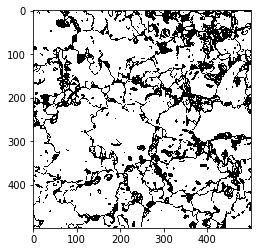

In [5]:
plt.imshow(bd_map,cmap="gray")

In [29]:
id2clus=dict() 
class_map=np.zeros([h,w]).astype("int") # c-> class #
# 0->martensite, 1->ferrite
cluster=Cluster(0,-1,-1)
id2clus[0]=cluster
c=0
if bd_map[0,0]:
    c+=1
    class_map[0,0]=c
else:
    class_map[0,0]=0 
cluster=Cluster(c,0,0)
id2clus[class_map[0,0]]=cluster
for i in range(h):#h
    for j in range(w):#w
        if i==0 :
            if j!=w-1:                
                if not bd_map[i,j+1]: #(1,0),(0,0)
                    id2clus[0].add(i,j+1)
                    class_map[i,j+1]=0
                elif bd_map[i,j] and bd_map[i,j+1] : #(1,1)
                    id2clus[class_map[i,j]].add(i,j+1)
                    class_map[i,j+1]=class_map[i,j]                    
                elif not bd_map[i,j] and bd_map[i,j+1] : #(0,1)
                    c+=1
                    class_map[i,j+1]=c
                    cluster=Cluster(c,i,j+1)
                    id2clus[class_map[i,j+1]]=cluster
        else:
            if j==0:
                if not bd_map[i,j]: #(x,0)
                    id2clus[0].add(i,j)
                    class_map[i,j]=0
                elif bd_map[i-1,j] and bd_map[i,j] : #(1,1)
                    id2clus[class_map[i-1,j]].add(i,j)
                    class_map[i,j]=class_map[i-1,j]      
                else: #(0,1)
                    c+=1
                    class_map[i,j]=c
                    cluster=Cluster(c,i,j)
                    id2clus[class_map[i,j]]=cluster
            else:
                if not bd_map[i,j]:
                    id2clus[0].add(i,j)
                    class_map[i,j]=0
                elif bd_map[i-1,j] and bd_map[i,j] : #(1,1)
                    id2clus[class_map[i-1,j]].add(i,j)
                    class_map[i,j]=class_map[i-1,j] 
                    if bd_map[i,j-1] and class_map[i,j]!=class_map[i,j-1]:
#                         print("neigh %d %d"%(class_map[i,j-1],class_map[i,j]))
                        id2clus[class_map[i,j-1]].addn(class_map[i,j])
                        id2clus[class_map[i,j]].addn(class_map[i,j-1])                    
                elif bd_map[i,j-1] and bd_map[i,j] : #(1,1)
                    id2clus[class_map[i,j-1]].add(i,j)
                    class_map[i,j]=class_map[i,j-1] 
                    if bd_map[i-1,j] and class_map[i,j]!=class_map[i-1,j]:
#                         print("neigh %d %d"%(class_map[i-1,j],class_map[i,j]))
                        id2clus[class_map[i-1,j]].addn(class_map[i,j])
                        id2clus[class_map[i,j]].addn(class_map[i-1,j])  
                else:
                    c+=1
                    class_map[i,j]=c
                    cluster=Cluster(c,i,j)
                    id2clus[class_map[i,j]]=cluster
                    
                

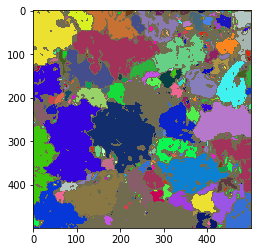

828


In [43]:

for i in range(1,c+1):
    if i in id2clus:
        for id in id2clus[i].neigh.copy():
            if id!=0:
                id2clus[i].merge(id,id2clus)
for id in list(id2clus.keys()):
    for (i,j) in id2clus[id].pixels:
        class_map[i,j]=id                
mat2plot(class_map)
plt.show()
# plt.imshow(train[ind][2][:,:,:3])
print(len(id2clus))
                    

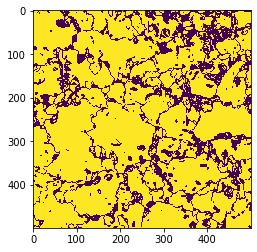

In [52]:
plt.imshow(bd_map)

In [3]:
class CNN3(nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()
        self.batchnorm = nn.BatchNorm2d(in_channel)
        self.relu = nn.ReLU() # activation
        self.maxpool = nn.MaxPool2d(kernel_size=2) 
        self.cnn1 = nn.Conv2d(in_channels=in_channel, out_channels=12, kernel_size=3, stride=1, padding=0) 
        self.cnn2 = nn.Conv2d(in_channels=12, out_channels=18, kernel_size=3, stride=1, padding=1) 
        self.cnn3 = nn.Conv2d(in_channels=18, out_channels=24, kernel_size=3, stride=1, padding=0) 
        self.fc1 = nn.Linear(24 * 5 * 5, 2) 
        self.softmax = nn.Softmax(1)
    def forward(self, x):
        # Convolution 1 50
        out = self.batchnorm(x)
        out = self.cnn1(x) # 48
        out = self.relu(out)
        out = self.maxpool(out) #24
        out = self.cnn2(out) #24
        out = self.relu(out) 
        out = self.maxpool(out) #12
        out = self.cnn3(out) #10
        out = self.relu(out)
        out = self.maxpool(out) #5
        out = out.view(out.size(0), -1)
        # Linear function (readout)
        out = self.fc1(out)
        out = self.softmax(out)
        return out
class CNN5(nn.Module):
    def __init__(self):
        super(CNN5, self).__init__()
        self.batchnorm = nn.BatchNorm2d(in_channel)
        self.relu = nn.ReLU() # activation
        self.maxpool = nn.MaxPool2d(kernel_size=2) 
        self.cnn1 = nn.Conv2d(in_channels=in_channel, out_channels=12, kernel_size=3, stride=1, padding=0) 
        self.cnn2 = nn.Conv2d(in_channels=12, out_channels=18, kernel_size=3, stride=1, padding=0) 
        self.cnn3 = nn.Conv2d(in_channels=18, out_channels=24, kernel_size=3, stride=1, padding=0) 
        self.fc1 = nn.Linear(24 * 9 * 9, 2) 
        self.softmax = nn.Softmax(1)
    def forward(self, x):
        # Convolution 1 50
        out = self.batchnorm(x)
        out = self.cnn1(x) # 48
        out = self.relu(out)
        out = self.maxpool(out) #24
        out = self.cnn2(out) #22
        out = self.relu(out) 
        out = self.maxpool(out) #11
        out = self.cnn3(out) #9
        out = self.relu(out)
        out = out.view(out.size(0), -1)
        # Linear function (readout)
        out = self.fc1(out)
        out = self.softmax(out)
        return out

In [4]:
train_loader= DataLoader(train, batch_size=64, shuffle=True,  num_workers=0, drop_last=True )
test_loader= DataLoader(test, batch_size=64, shuffle=True,  num_workers=0,  drop_last=False )

NameError: name 'train' is not defined

In [5]:
in_channel=train[0][0].shape[0]
model = CNN3()
Loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
max_acc = 0
epoch = 400
for ep in range(epoch):
    for batch_ndx, sample in enumerate(train_loader):
        optimizer.zero_grad()
        X,Y,_= sample
        output=model(X)
        loss = Loss(output,Y)
        loss.backward()
        optimizer.step()
#         print("train ",ep,loss.item())
    model.eval()
    cum=0
    loss=0
    for batch_ndx, sample in enumerate(test_loader):
        X,Y,_= sample
        output=model(X)
        loss+=Loss(output,Y)
        predict = torch.max(output, 1)[1]
        cum+=np.sum((Y == predict).cpu().numpy())
    acc=cum/len(test)
    if acc>max_acc:
        max_acc=acc
        min_loss = loss.item()
        print(ep,min_loss)
        print("acc= ",cum,"/",len(test))
        torch.save(model,"model/%s_obcbs_%.3f"%(type(model).__name__,acc))
        
    

0 1.4328786134719849
acc=  50 / 102
1 1.3680508136749268
acc=  52 / 102


/home/kisaki/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type CNN3. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


2 1.3709940910339355
acc=  55 / 102
6 1.348008394241333
acc=  61 / 102
7 1.3372080326080322
acc=  69 / 102
10 1.32179856300354
acc=  71 / 102
16 1.2909302711486816
acc=  74 / 102
23 1.2593402862548828
acc=  77 / 102
27 1.235084056854248
acc=  78 / 102
37 1.1921640634536743
acc=  79 / 102


In [6]:
# m1 = torch.load("model/CNN5_0.755")
# m2 = torch.load("model/CNN3_0.765")
# m1.eval()
# m2.eval()
# cum=0
# for batch_ndx, sample in enumerate(test_loader):
#     X,Y,_= sample
#     output=m2(X)+m1(X)
#     predict = torch.max(output, 1)[1]
#     cum+=np.sum((Y == predict).cpu().numpy())
# print(cum/len(test))

In [7]:
# model = torch.load("model/0.765")
# corner=torch.load("data/corner.pkl")
# for param in model.parameters():
#     param.requires_grad = False
# index=1
# X=test[index][0].unsqueeze(0)
# print(test[index][1])

# # we would run the model in evaluation mode
# model.eval()

# # we need to find the gradient with respect to the input image, so we need to call requires_grad_ on it
# X.requires_grad_()

# '''
# forward pass through the model to get the scores, note that VGG-19 model doesn't perform softmax at the end
# and we also don't need softmax, we need scores, so that's perfect for us.
# '''

# scores = model(X)
# print(scores)
# # Get the index corresponding to the maximum score and the maximum score itself.
# score_max_index = scores.argmax()
# score_max = scores[0,score_max_index]

# '''
# backward function on score_max performs the backward pass in the computation graph and calculates the gradient of 
# score_max with respect to nodes in the computation graph
# '''
# score_max.backward()

# '''
# Saliency would be the gradient with respect to the input image now. But note that the input image has 3 channels,
# R, G and B. To derive a single class saliency value for each pixel (i, j),  we take the maximum magnitude
# across all colour channels.
# '''
# saliency, _ = torch.max(X.grad.data.abs(),dim=1)

# # code to plot the saliency map as a heatmap
# plt.imshow(saliency[0], cmap=plt.cm.hot)
# plt.axis('off')
# plt.show()
# cv2.imwrite("output/t1.png",(255*test[index][2][:,:,6:]).astype("int"))
# plt.imshow((255*test[index][2][:,:,6:]).astype("int"))